# arXiv Matplotlib Query

Anecdotally the Matplotlib maintainers were told 

*"About 15% of arXiv papers use Matplotlib"*

Unfortunately the original analysis of this data was lost.  We reproduce it here.

## Watermark

Starting in the early 2010s, Matplotlib started including the bytes `b"Matplotlib"` in every PNG and PDF that they produce.  These bytes persist in PDFs that contain Matplotlib plots, including the PDFs stored on arXiv.  As a result, it's pretty simple to check if a PDF contains a Matplotlib image.  All we have to do is scan through every PDF and look for these bytes; no parsing required.

## Data

The data is stored in a requester pays bucket at s3://arxiv (more information at https://arxiv.org/help/bulk_data_s3 ) and also on GCS hosted by Kaggle (more information at https://www.kaggle.com/datasets/Cornell-University/arxiv).  

The data is about 1TB in size.  We're going to use Dask for this.

### Get all filenames

In [1]:
import s3fs
s3 = s3fs.S3FileSystem(requester_pays=True)

directories = s3.ls("s3://arxiv/pdf")
len(directories)

5288

In [2]:
directories[1000]

'arxiv/pdf/arXiv_pdf_1407_009.tar'

## Process one file

Mostly we have to muck about with tar files.  This wasn't hard.  The `tarfile` library is in the stardard library.  It's not beautiful, but it's also not hard to use.

In [3]:
import tarfile
import io

def extract(filename):
    out = []
    with s3.open(filename) as f:
        bytes = f.read()
        with io.BytesIO() as bio:
            bio.write(bytes)
            bio.seek(0)
            with tarfile.TarFile(fileobj=bio) as tf:
                for member in tf.getmembers():
                    if member.isfile() and member.name.endswith(".pdf"):
                        data = tf.extractfile(member).read()
                        out.append((
                            member.name, 
                            b"matplotlib" in data.lower()
                        ))
            return out

In [4]:
# See an example of its use
extract(directories[20])[:10]

[('0011/cs0011019.pdf', False),
 ('0011/gr-qc0011017.pdf', False),
 ('0011/hep-ex0011095.pdf', False),
 ('0011/cond-mat0011373.pdf', False),
 ('0011/hep-ph0011035.pdf', False),
 ('0011/gr-qc0011082.pdf', False),
 ('0011/cond-mat0011202.pdf', False),
 ('0011/hep-ph0011209.pdf', False),
 ('0011/cond-mat0011038.pdf', False),
 ('0011/gr-qc0011014.pdf', False)]

# Scale function to full dataset

## Create Dask Cluster

We start a Dask cluster on AWS in the same region where the data is stored.  

We mimic the local software environment on the cluster with `package_sync=True`.

In [5]:
import coiled

cluster = coiled.Cluster(
    n_workers=100,
    name="arxiv",
    package_sync=True, 
    backend_options={"region": "us-east-1"},
)

╭───────────────────────────────────────── Package Issues ─────────────────────────────────────────╮
│                    ╷                                                           ╷                 │
│   Package          │ Issue                                                     │ Risk Level      │
│ ╶──────────────────┼───────────────────────────────────────────────────────────┼───────────────╴ │
│   libgfortran5     │ 11.3.0 has no install candidate for linux-64              │                 │
│   libgfortran      │ 5.0.0 has no install candidate for linux-64               │                 │
│   grpcio           │ 1.47.1 has no install candidate for linux-64              │                 │
│   grpc-cpp         │ 1.47.1 has no install candidate for linux-64              │                 │
│   arrow-cpp        │ 9.0.0 has no install candidate for linux-64               │                 │
│   openssl          │ Package ignored                                           │                 │
│   libabseil        │ Package ignored                                           │                 │
│                    ╵                                                           ╵                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [6]:
from dask.distributed import Client, wait
client = Client(cluster)

### Map function across every directory

Let's scale up this work across all of the directories in our dataset

Hopefully it will also be faster because the Dask workers are in the same region as the dataset itself.

In [7]:
%%time
futures = client.map(extract, directories)
wait(futures)

# We had one error in one file.  Let's just ignore and move on.
good = [future for future in futures if future.status == "finished"]

lists = client.gather(good)

CPU times: user 17.3 s, sys: 5.03 s, total: 22.3 s
Wall time: 7min 11s


In [8]:
# Scale down now that we're done
cluster.close()

In [10]:
# Convert to Pandas

import pandas as pd

dfs = [
    pd.DataFrame(list, columns=["filename", "has_matplotlib"]) 
    for list in lists
]

df = pd.concat(dfs)

df

,filename,has_matplotlib
0,0001/astro-ph0001477.pdf,False
1,0001/hep-th0001095.pdf,False
2,0001/astro-ph0001322.pdf,False
3,0001/cond-mat0001159.pdf,False
4,0001/astro-ph0001132.pdf,False
...,...,...
630,9912/math9912098.pdf,False
631,9912/math9912251.pdf,False
632,9912/solv-int9912013.pdf,False
633,9912/hep-th9912254.pdf,False


## Enrich Data

We're pretty much done with Dask now that the dataset has been reduced.  We're back to iterating with plain Pandas.

Let's enhance our data a bit. 

In [11]:
def date(filename):
    year = int(filename.split("/")[0][:2])
    month = int(filename.split("/")[0][2:4])
    if year > 80:
        year = 1900 + year
    else:
        year = 2000 + year
    
    return pd.Timestamp(year=year, month=month, day=1)

date("0005/astro-ph0001322.pdf")

Timestamp('2000-05-01 00:00:00')

In [12]:
df["date"] = df.filename.map(date)
df.head()

,filename,has_matplotlib,date
0,0001/astro-ph0001477.pdf,False,2000-01-01
1,0001/hep-th0001095.pdf,False,2000-01-01
2,0001/astro-ph0001322.pdf,False,2000-01-01
3,0001/cond-mat0001159.pdf,False,2000-01-01
4,0001/astro-ph0001132.pdf,False,2000-01-01


## Plot

Now we can just fool around with Pandas and Matplotlib.

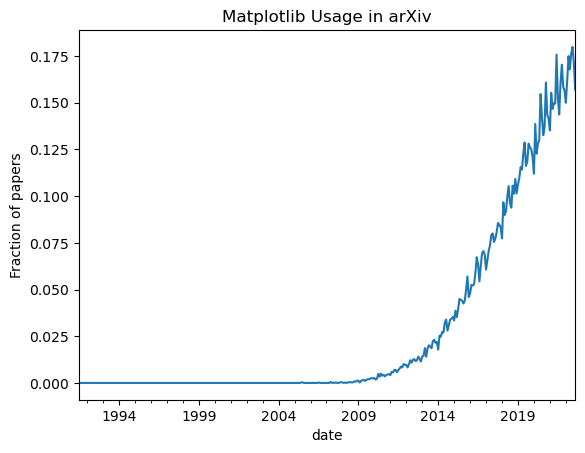

In [13]:
df.groupby("date").has_matplotlib.mean().plot(
    title="Matplotlib Usage in arXiv", 
    ylabel="Fraction of papers"
).get_figure().savefig("results.png")

Yup.  Matplotlib is used pretty commonly on arXiv.  Go team.

## Save results

This data was slighly painful to procure.  Let's save the results locally for future analysis.

In [14]:
df.to_csv("arxiv-matplotlib.csv")

In [15]:
!du -hs arxiv-matplotlib.csv

 96M	arxiv-matplotlib.csv


In [16]:
df.to_parquet("arxiv-matplotlib.parquet", compression="snappy")

In [17]:
!du -hs arxiv-matplotlib.parquet

 12M	arxiv-matplotlib.parquet


## Conclusion

### Matplotlib + arXiv

It's incredible to see the steady growth of Matplotlib across arXiv.  It's worth noting that this is *all* papers, even from fields like theoretical mathematics that are unlikely to include computer generated plots.  Is this matplotlib growing in popularity?  Is it Python generally?

For future work, we should break this down by subfield.  The filenames actually contained the name of the field for a while, like "hep-ex" for "high energy physics, experimental", but it looks like arXiv stopped doing this at some point.  My guess is that there is a list mapping filenames to fields somewhere though.  The filenames are all in the Pandas dataframe / parquet dataset, so doing this analysis shouldn't require any scalable computing.

### Dask + Coiled

Dask and Coiled were built to make it easy to answer large questions.  

We started this notebook with some generic Python code.  When we wanted to scale up we invoked Dask+Coiled, did some work, and then tore things down.  The problem of scale or "big data" didn't get in the way of us analyzing data and making a delightful discovery. 

This is exactly why these projects exist.